### AP3
moving most of processing code into one cell

allowing parameters to change how data is constructed

In [1]:
import os, sys, json, copy, random
import pandas as pd
import numpy as np
from fastai.vision import *
from fastai.utils.mem import  gpu_mem_get_free_no_cache
gpu_mem_get_free_no_cache()

7601

In [2]:
data_dir = Path('data/alphapilot/')
raw_fn = data_dir/'data_training'
label_fn = data_dir/'truth_df.csv'

if os.name == 'nt':      ##local
    data_dir = Path('../../../../alphapilot/')
    raw_fn = data_dir/'Data_Training/Data_Training/'
    label_fn = data_dir/'truth_df.csv'

##### Build Data

In [3]:
#load ground truth
truth_df = pd.read_csv(label_fn, index_col=0)
assert truth_df.shape == (8, 5827)

In [4]:
# helper functions to build-dataset

TRUTH_INDS  = list(truth_df.columns)

def filter_img_by_truth(fn):
    ''' only use data records in truth_df'''
    return fn.name in TRUTH_INDS

filter_records = filter_img_by_truth

def label_points(fn):
    '''
        input:  x0,y0,...x3,y3 (list)
        output: [y0,x0],...[y3,x3] (list) 
         
        >use y_first=True in label-load-func
    '''
    p = truth_df[fn.name]
    return tensor([ [ float(p[i*2+1]), float(p[i*2+0]) ] for i in range(4)])

def mod_img_divisor(h,w):
    return [ i for i in range(2, min(h,w) // 2) 
               if (h % i ==0) and (w % i ==0 )
           ]

In [5]:
# view different sizes
IMG_SHAPE = [864, 1296]
divisors = mod_img_divisor(*IMG_SHAPE)
[e for e in [tensor(IMG_SHAPE) / e for e in divisors] if e[0] > 50]

[tensor([432, 648]),
 tensor([288, 432]),
 tensor([216, 324]),
 tensor([144, 216]),
 tensor([108, 162]),
 tensor([ 96, 144]),
 tensor([ 72, 108]),
 tensor([54, 81])]

In [9]:
#Parameters to build-dataset

_numworkers = {}
if os.name == 'nt':
    _numworkers['num_workers'] = 0
    
_batchsize = 4
_size = (216, 324)

In [10]:
data = (PointsItemList.from_folder(raw_fn)
        .filter_by_func(filter_records)
        .split_by_rand_pct(valid_pct=0.2)
        .label_from_func(label_points)
        .transform(get_transforms()
                            ,tfm_y=True
                            ,size=_size
                            ,remove_out=False
                           )    
         .databunch(bs=_batchsize, **_numworkers)
         .normalize(imagenet_stats)
       )

In [27]:
# run asserts here to check data
assert isinstance(data, ImageDataBunch)
assert len(data.train_dl.x.items) == 4662
assert len(data.valid_dl.x.items) == 1165
assert list(data.valid_dl.y.items[0].shape) == [4,2]
assert list(data.valid_dl.x.get(0).shape) == [3, 864, 1296]
assert data.num_workers == (0 if os.name == 'nt' else 8)

##### Train

In [13]:
learn = cnn_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


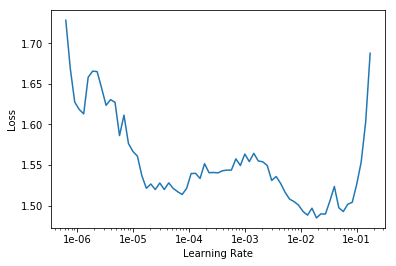

In [14]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 2e-3
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,0.443529,0.138282,01:15
1,0.065398,0.041553,01:15
2,0.053497,0.032882,01:14
3,0.046617,0.024667,01:14
4,0.042883,0.025179,01:15
5,0.037611,0.023884,01:16
6,0.032920,0.021571,01:15


In [ ]:
lr = 1e-5
learn2 = cnn_learner(data, models.resnet34)
learn2.fit_one_cycle(10, slice(lr))

##### Saving Progress

In [ ]:
learn.save('ap3-2e3-10')
learn2.save('ap3-1e5-10')

In [19]:
# erroneous learn.path, was inseted in databunch() operation, 
# should point to old-models/ on the cloud (if possible)
# but usually data_dir/models/my.pth
learn.path

PosixPath('num_workers')

##### Import / Export

In [17]:
# export as pkl
defaults.device = torch.device('cpu')

export_fn = Path(os.getcwd())
export_fn = export_fn/'old-models'/'ap-1-cpu.pkl'

learn.export(export_fn)

In [10]:
import_fn = Path(os.getcwd())
import_fn = import_fn/'old-models'

pathlike_fn = import_fn/'ap-1-cpu.pkl'

# load pkl
learn2 = load_learner(path='', fname=pathlike_fn)

##### Graphical Display

In [137]:
# helper functions for working with 

def scaled_pts(pts):
    ''' use a helper function to convert coords flow->absolute
        input  pts - an ImagePoints object
        output tensor(4,2)
    '''
    return scale_flow(
                FlowField(pts.size, pts.data)
                            ,to_unit=False
                        ).flow.flip(1)

def scaled_pts_2(data_slice, item_num):
    ''' use a secondary pattern to convert coords flow->absolute:
        input data_slice=data_final.valid_dl
              item_num=0
        output tensor(4,2)
    '''
    pll = PointsLabelList([])
    re_pts = pll.reconstruct( data_slice.y.items[item_num]
                             ,data_slice.x.get(item_num))
    return re_pts.data

def get_ip(img,pts): 
    ''' converts plain tensor representing points to an 
        ImagePoints obj; useful for inserting into show(y=?)
    '''
    return ImagePoints(FlowField(img.size, pts), 
                       scale=True,  
                       y_first=True)

def clean_preds(pred_pts):
    '''remove out-of-bounds from coords'''
    pass

200 IMG_8806.JPG
tensor([[ 111.,  594.],
        [ 202., 1004.],
        [ 697., 1007.],
        [ 755.,  592.]])
----
tensor([[78.0546, 29.1903],
        [92.4405, 28.9957],
        [92.4121, 83.5083],
        [78.2821, 83.9489]])


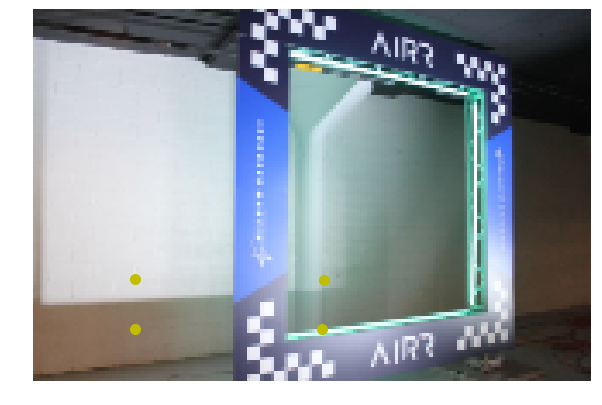

In [140]:
i = 200
# i = np.random.randint(0, len(data_final.valid_dl.x.items) - 1)

fn =  data_final.valid_dl.x.items[i]
img = data_final.valid_dl.x.get(i)
truth_pts = data_final.valid_dl.y.items[i]

pred_pts = learn2.predict(img)  #outputs tuple(ImgPts obj, data)
scaled_pred_pts = scaled_pts(pred_pts[0])

img2 = img.clone()
img2.resize(size=(3,108,162))

print(i, fn.name); print(truth_pts); print('----')
print(scaled_pred_pts) #TODO - put on same terms as ground-truth, round

img2.show( 
          # y=get_ip(img, truth_pts)
          y=get_ip(img, scaled_pred_pts)
         ,figsize=(10, 10)
         ,c='y' ,marker='o', s=100
        )